In [2]:
import math
import matplotlib.pyplot as plt
import random

#LIF

In [3]:
class LIF():


    def __init__(self, I, total_time_ms=100, delta_t_ms=0.1, neuron_type='Excitatory',
    treshold=-45, u_rest=-70, start_u=-80, u_reset=-65, u_spike=5, R=10, tau=8, 
    is_exponential=False, delta_T=1, theta_r_h=-55,
    is_adaptive=False, a=0.01, b=0.5, tau_w=1):
        self.I = I
        self.total_time_ms = total_time_ms
        self.delta_t_ms = delta_t_ms
        self.neuron_type = neuron_type
        self.u_t = []
        self.w_t = []
        self.fire_count = 0
        self.u = start_u
        self.start_u = start_u
        self.treshold = treshold
        self.u_rest = u_rest
        self.u_reset = u_reset
        self.u_spike = u_spike
        self.R = R
        self.tau = tau
        self.is_exponential = is_exponential
        self.delta_T = delta_T
        self.theta_r_h = theta_r_h
        self.is_adaptive = is_adaptive
        self.a = a
        self.b = b
        self.tau_w = tau_w
        self.w = 0

    def start(self):
        current_time = 0
        while current_time <= self.total_time_ms:
            exponential_value = 0
            adaptation_value = 0
            delta_u = self.u - self.u_rest

            if self.is_adaptive:
                dw = (self.a * delta_u - self.w) / self.tau_w 
                dw += self.b * self.fire_count
                self.w += dw * self.delta_t_ms
                adaptation_value = self.R * self.w


            if self.is_exponential:
                exponential_value = self.delta_T * math.exp((self.u - self.theta_r_h)/self.delta_T)

            du = -1 * delta_u + exponential_value - adaptation_value + self.R * self.I(current_time)
            du /= self.tau
            
            self.u += du * self.delta_t_ms
            is_spike = False
            if self.u >= self.treshold:
                self.u_t.append(self.u + self.u_spike)
                self.fire_count += 1
                self.u = self.u_reset
                is_spike = True

            self.w_t.append(self.w)
            self.u_t.append(self.u)

            current_time += self.delta_t_ms

            yield {'u': self.u, 'is_spike': is_spike}


    def u_t_plot(self):
        plt.plot(list(map(lambda i: i * self.delta_t_ms, range(len(self.u_t)))), self.u_t)
        plt.show()


    def w_t_plot(self):
        if self.is_adaptive == True:
          plt.plot(list(map(lambda i: i * self.delta_t_ms, range(len(self.w_t)))), self.w_t)
          plt.show()
        else:
          print("This model isn't adaptive")



#Neurons Group

In [4]:
class NeuronsGroup:

  def __init__(self, neurons, connections, excw=10, inhw=-10, exc_delay=1, inh_delay=1, iteration_count=1000):
    self.neurons = neurons
    self.neroun_action = []
    for i in neurons:
      self.neroun_action.append(i.start())

    self.connections = connections
    self.excw = excw
    self.inhw = inhw
    self.iteration_count = iteration_count
    self.spikes = []
    self.exc_spikes_time = []
    self.exc_spikes = []
    self.inh_spikes_time = []
    self.inh_spikes = []
    self.exc_delay = exc_delay
    self.inh_delay = inh_delay
    self.spikes_effect = []

  def start(self):
    self.spikes_effect = [[0] * len(self.neurons) for _ in range(self.iteration_count)]
    for t in range(self.iteration_count):
      flag = False
      
      for i in range(len(self.neroun_action)):

        action_info = next(self.neroun_action[i])
        if action_info['is_spike']:
          
          for j in self.connections[i]:
            if self.neurons[i].neuron_type == 'Excitatory':
              self.exc_spikes.append(i + 1)
              self.exc_spikes_time.append(t)
              if t+self.exc_delay < self.iteration_count:
                self.spikes_effect[t + self.exc_delay][j] += self.excw

            if self.neurons[i].neuron_type == 'Inhibitory':
              self.inh_spikes.append(i + 1)
              self.inh_spikes_time.append(t)
              if t+self.inh_delay < self.iteration_count:
                self.spikes_effect[t+self.inh_delay][j] += self.inhw
      for i in range(len(self.neurons)):
        self.neurons[i].u += self.spikes_effect[t][i]
      

  def neurons_u_plot(self, neurons_count=5):
    legend = []
    for i in range(min(neurons_count, len(self.neurons))):
      plt.plot(list(map(lambda j: j * self.neurons[i].delta_t_ms, range(len(self.neurons[i].u_t)))), self.neurons[i].u_t)
      legend.append('neuron ' + str(i+1))
    plt.legend(legend)

  def raster_plot(self):
    plt.scatter(self.exc_spikes_time, self.exc_spikes, color='blue', s=10)
    plt.scatter(self.inh_spikes_time, self.inh_spikes, color='red', s=10)
    plt.legend(['Excitatory', 'Inhibitory'])
  

## Neurons Group Test 1

Text(0.5, 1.0, 'neuron2')

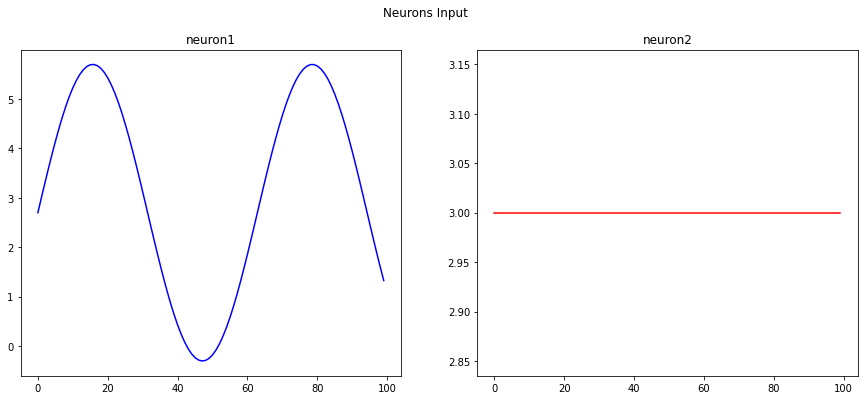

In [5]:
I1 = lambda x: 3 * (math.sin(x/10) + 0.9)
I2 = lambda x: 3
neuron1 = LIF(I=I1)
neuron2 = LIF(I=I2)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 6)
fig.suptitle('Neurons Input')
ax1.plot(range(100), list(map(I1, range(100))), 'b')
ax1.set_title('neuron1')
ax2.plot(range(100), list(map(I2, range(100))), 'r')
ax2.set_title('neuron2')



In [6]:
neurons = [neuron1, neuron2]
connections = [[1], [0]]
neurons_group = NeuronsGroup(neurons, connections)
neurons_group.start()

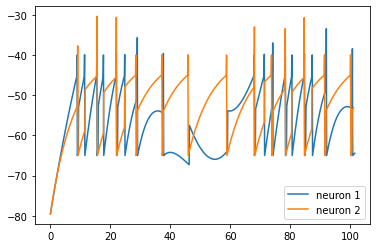

In [7]:
neurons_group.neurons_u_plot()

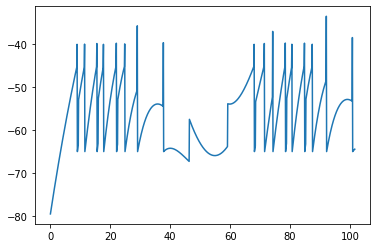

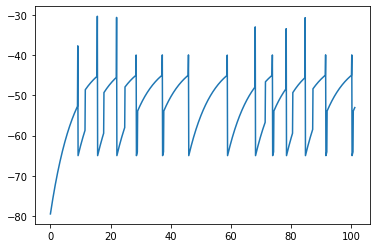

In [8]:
neuron1.u_t_plot()
neuron2.u_t_plot()

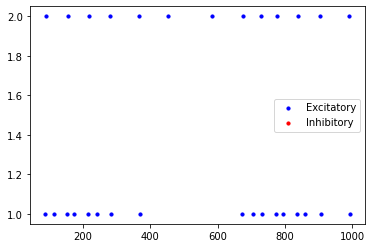

In [9]:
neurons_group.raster_plot()

## Neurons Group Test 2

In [10]:
I = lambda x: 3

neuron1 = LIF(I=I, treshold=-55)
neuron2 = LIF(I=I)
neuron3 = LIF(I=I)
neuron4 = LIF(I=I, neuron_type='Inhibitory')


In [11]:
neurons = [neuron1, neuron2, neuron3, neuron4]
connections = [[1, 2, 3], [0, 2, 3], [0, 1, 3], [0, 1, 2]]
neurons_group = NeuronsGroup(neurons, connections, inhw=-15, exc_delay=3, inh_delay=5)
neurons_group.start()

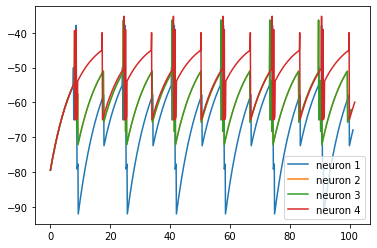

In [12]:
neurons_group.neurons_u_plot()

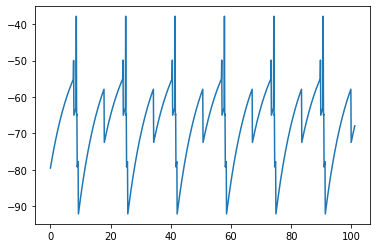

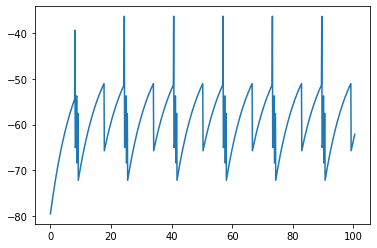

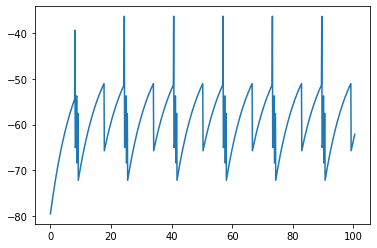

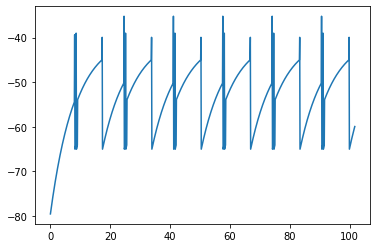

In [13]:
neuron1.u_t_plot()
neuron2.u_t_plot()
neuron3.u_t_plot()
neuron4.u_t_plot()


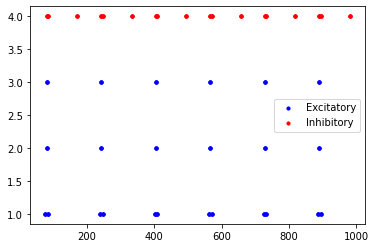

In [14]:
neurons_group.raster_plot()

## Neuron Group Test 3

Text(0.5, 1.0, 'neuron4: Inhibitory')

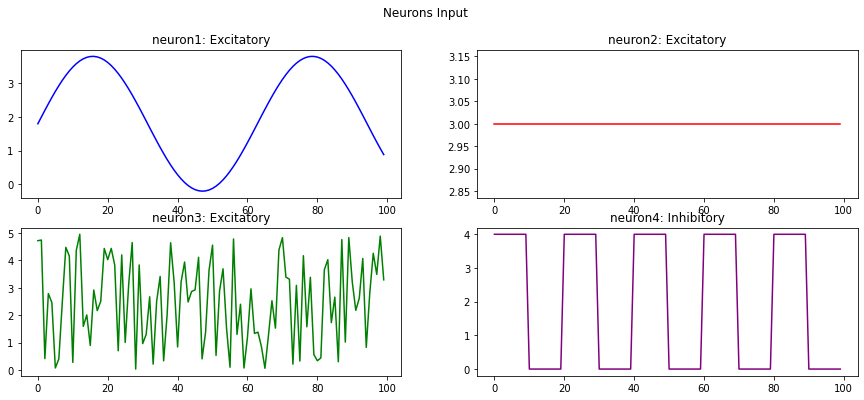

In [15]:
I1 = lambda x: 2 * (math.sin(x/10) + 0.9)
I2 = lambda x: 3
I3 = lambda x: random.random() * 5

def I4(x):
  if int(x/10)%2 == 0:
    return 4
  return 0

neuron1 = LIF(I=I1, treshold=-50)
neuron2 = LIF(I=I2)
neuron3 = LIF(I=I3, treshold=-50)
neuron4= LIF(I=I4, neuron_type='Inhibitory')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(15, 6)
fig.suptitle('Neurons Input')
ax1.plot(range(100), list(map(I1, range(100))), 'b')
ax1.set_title('neuron1: Excitatory')
ax2.plot(range(100), list(map(I2, range(100))), 'r')
ax2.set_title('neuron2: Excitatory')
ax3.plot(range(100), list(map(I3, range(100))), 'green')
ax3.set_title('neuron3: Excitatory')
ax4.plot(range(100), list(map(I4, range(100))), 'purple')
ax4.set_title('neuron4: Inhibitory')


In [16]:
neurons = [neuron1, neuron2, neuron3, neuron4]
connections = [[1, 2, 3], [0, 2, 3], [0, 1, 3], [0, 1, 2]]
neurons_group = NeuronsGroup(neurons, connections, excw=10, inhw=-20, exc_delay=10, inh_delay=10)
neurons_group.start()

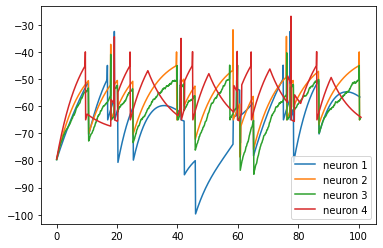

In [17]:
neurons_group.neurons_u_plot()

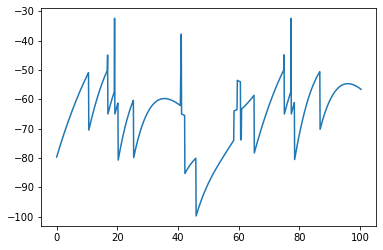

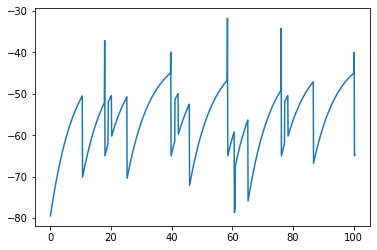

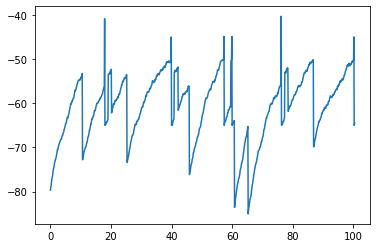

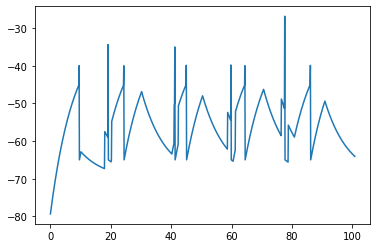

In [18]:
neuron1.u_t_plot()
neuron2.u_t_plot()
neuron3.u_t_plot()
neuron4.u_t_plot()

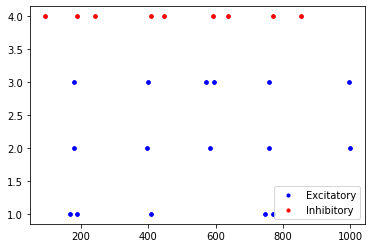

In [19]:
neurons_group.raster_plot()

# Create Neurons Group

In [20]:
def create_neuron_group(neurons_count, exc_count, inh_count, exc_prob, inh_prob, I, **kwargs):
  neurons = []
  connections = []
  exc_neuron_conn_count = int(neurons_count * exc_prob)
  inh_neuron_conn_count = int(neurons_count * inh_prob)

  for i in range(exc_count):
    args = {}
    if 'Excitatory' in kwargs.keys():
      for arg in kwargs['Excitatory']:
        args[arg] = kwargs[arg][i]
    neuron = LIF(I[i], neuron_type='Excitatory', **args)
    neurons.append(neuron)
    connections.append(random.sample(range(neurons_count), exc_neuron_conn_count))
  for i in range(inh_count):
    args = {}
    if 'Inhibitory' in kwargs.keys():
      for arg in kwargs['Inhibitory']:
        args[arg] = kwargs[arg][i]
    neuron = LIF(I[i], neuron_type='Inhibitory', **args)
    neurons.append(neuron)
    connections.append(random.sample(range(neurons_count), inh_neuron_conn_count))
  
  neurons_group = NeuronsGroup(neurons, connections, **kwargs)
  return neurons_group
   



# 80 Excitatory neuron and 20 Inhibitory neuron simulation

## Constant Input Current

Text(0.5, 1.0, 'Input current')

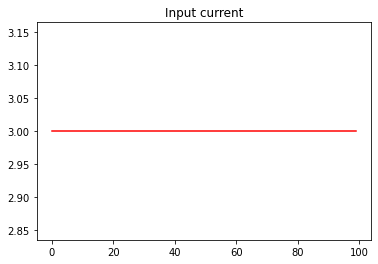

In [21]:
Is = []
for i in range(100):
  I = lambda x: 3
  Is.append(I)


plt.plot(range(100), list(map(Is[0], range(100))), 'r')
plt.title('Input current')


Excitatory probablity = 0.02

Inhibitory probablity = 0.03

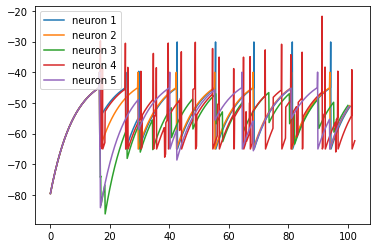

In [22]:
ng = create_neuron_group(100, 80, 20, 0.02, 0.03, Is)

ng.start()
ng.neurons_u_plot()

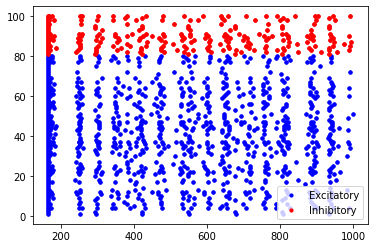

In [23]:
ng.raster_plot()

Excitatory probablity = 0.03

Inhibitory probablity = 0.03

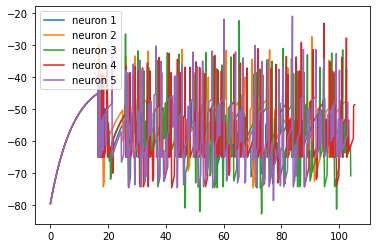

In [24]:
ng = create_neuron_group(100, 80, 20, 0.03, 0.03, Is)

ng.start()
ng.neurons_u_plot()

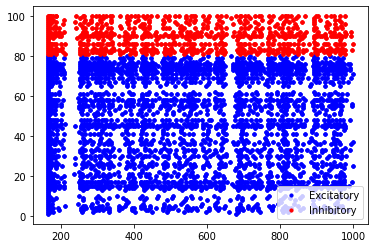

In [25]:
ng.raster_plot()

Excitatory probablity = 0.02

Inhibitory probablity = 0.04

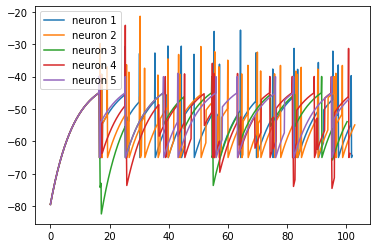

In [26]:
ng = create_neuron_group(100, 80, 20, 0.02, 0.04, Is)

ng.start()
ng.neurons_u_plot()

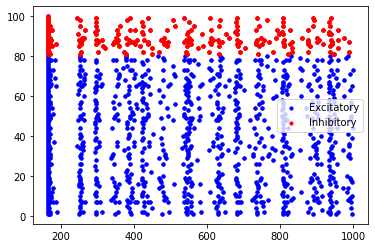

In [27]:
ng.raster_plot()

## Sin Input Current

Text(0.5, 1.0, 'Input current')

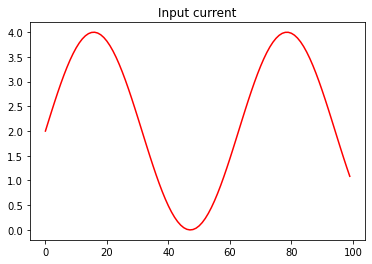

In [28]:
Is = []
for i in range(100):
  I = lambda x: 2 * math.sin(x/10) + 2
  Is.append(I)


plt.plot(range(100), list(map(Is[0], range(100))), 'r')
plt.title('Input current')

Excitatory probablity = 0.02

Inhibitory probablity = 0.03

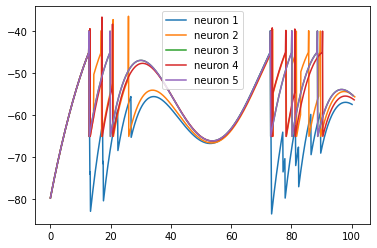

In [29]:
ng = create_neuron_group(100, 80, 20, 0.02, 0.03, Is)

ng.start()
ng.neurons_u_plot()

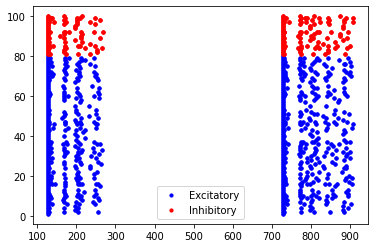

In [30]:
ng.raster_plot()

Excitatory probablity = 0.03

Inhibitory probablity = 0.03

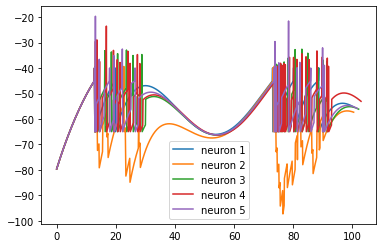

In [31]:
ng = create_neuron_group(100, 80, 20, 0.03, 0.03, Is)

ng.start()
ng.neurons_u_plot()

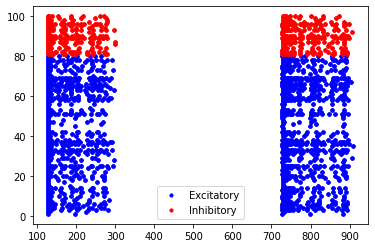

In [32]:
ng.raster_plot()

Excitatory probablity = 0.02

Inhibitory probablity = 0.04

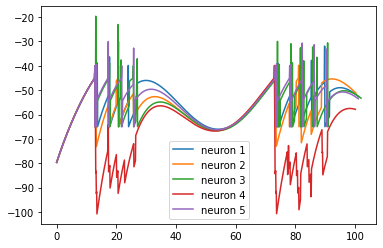

In [33]:
ng = create_neuron_group(100, 80, 20, 0.02, 0.04, Is)

ng.start()
ng.neurons_u_plot()

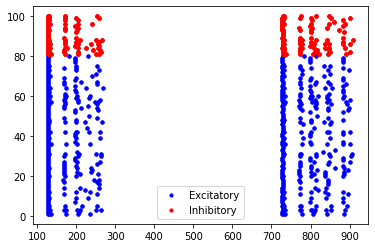

In [34]:
ng.raster_plot()

## Step Input Current

Text(0.5, 1.0, 'Input current')

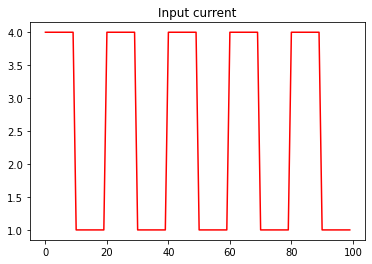

In [35]:
def I(x):
  if (x // 10) % 2 == 0:
    return 4
  return 1
Is = []
for i in range(100):
  Is.append(I)

plt.plot(range(100), list(map(Is[0], range(100))), 'r')
plt.title('Input current')

Excitatory probablity = 0.02

Inhibitory probablity = 0.03

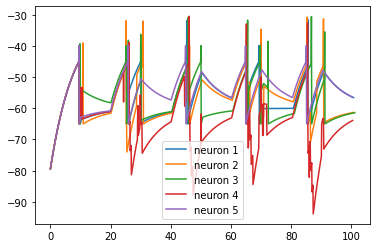

In [36]:
ng = create_neuron_group(100, 80, 20, 0.02, 0.03, Is)

ng.start()
ng.neurons_u_plot()

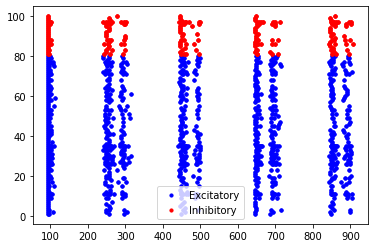

In [37]:
ng.raster_plot()

## Random Input Current

Text(0.5, 1.0, 'Input current')

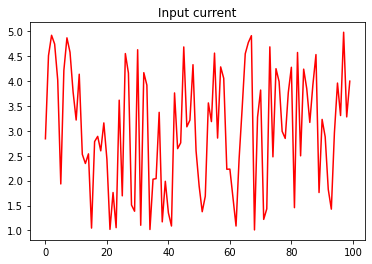

In [38]:
Is = []
for i in range(100):
  I = lambda x: random.random() * 4 + 1
  Is.append(I)


plt.plot(range(100), list(map(Is[0], range(100))), 'r')

plt.title('Input current')

Excitatory probablity = 0.05

Inhibitory probablity = 0.1

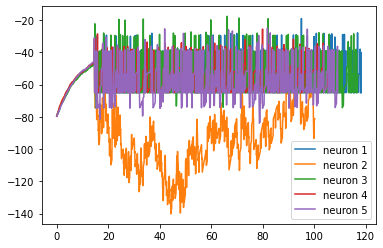

In [39]:
ng = create_neuron_group(100, 80, 20, 0.05, 0.1, Is)

ng.start()
ng.neurons_u_plot()

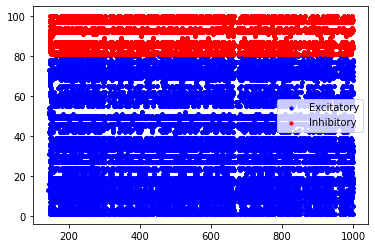

In [40]:
ng.raster_plot()

Excitatory probablity = 0.5

Inhibitory probablity = 0.2

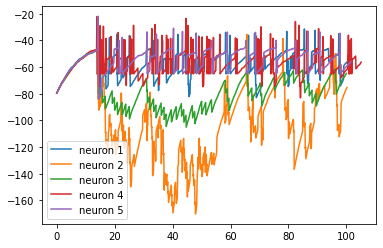

In [41]:
ng = create_neuron_group(100, 80, 20, 0.05, 0.2, Is)

ng.start()
ng.neurons_u_plot()

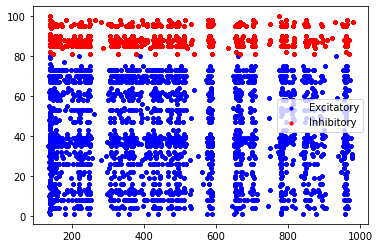

In [42]:
ng.raster_plot()

##Constant Input to some of neurons
half of neurons get constant input 

In [43]:
I1 = lambda x: 4
I2 = lambda x: 0
Is = []
for i in range(100):
  if i % 2 == 0:
    Is.append(I1)
  else:
    Is.append(I2)

Text(0.5, 1.0, 'Input current - 1')

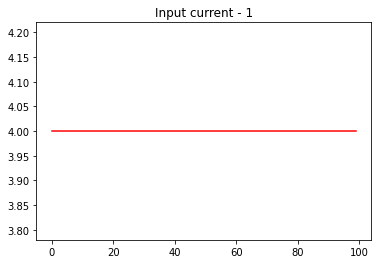

In [44]:
plt.plot(range(100), list(map(Is[0], range(100))), 'r')

plt.title('Input current - 1')

Text(0.5, 1.0, 'Input current - 2')

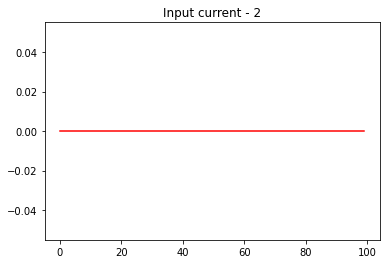

In [45]:
plt.plot(range(100), list(map(Is[1], range(100))), 'r')

plt.title('Input current - 2')

Excitatory probablity = 0.05

Inhibitory probablity = 0.2

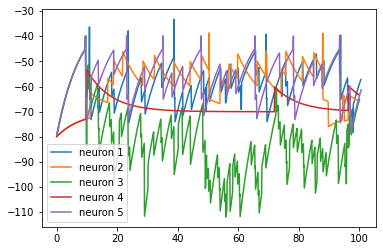

In [46]:
ng = create_neuron_group(100, 80, 20, 0.05, 0.2, Is)

ng.start()
ng.neurons_u_plot()

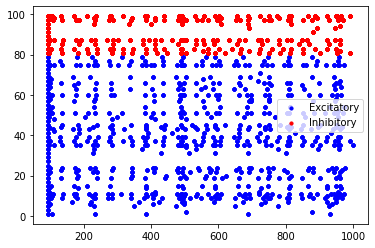

In [47]:
ng.raster_plot()

Excitatory probablity = 0.1

Inhibitory probablity = 0.2

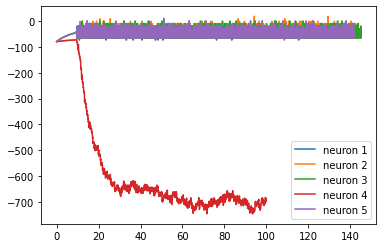

In [48]:
ng = create_neuron_group(100, 80, 20, 0.1, 0.2, Is)

ng.start()
ng.neurons_u_plot()

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


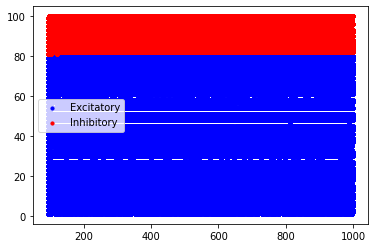

In [49]:
ng.raster_plot()

#Connecting Neurons Groups

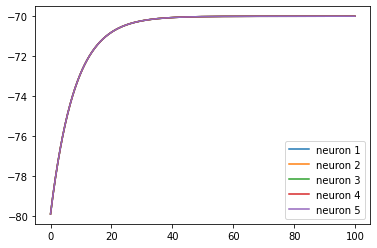

In [50]:
inh_I = []
for i in range(100):
  I = lambda x: 0
  inh_I.append(I)


test_neuron_group = create_neuron_group(100, 0, 100, 0, 0.1, inh_I)
test_neuron_group.start()
test_neuron_group.neurons_u_plot()

In [51]:
class NeuronsGroup:

  def __init__(self, neurons, connections, spikes_threshold = 20, connected_neuron_groups_effect = 2,
               excw=10, inhw=-10, exc_delay=1, inh_delay=1, iteration_count=1000):
    self.neurons = neurons
    self.neroun_action = []
    for i in neurons:
      self.neroun_action.append(i.start())

    self.connections = connections
    self.excw = excw
    self.inhw = inhw
    self.iteration_count = iteration_count
    self.spikes = []
    self.exc_spikes_time = []
    self.exc_spikes = []
    self.inh_spikes_time = []
    self.inh_spikes = []
    self.exc_delay = exc_delay
    self.inh_delay = inh_delay
    self.spikes_effect = []
    self.connected_neuron_groups = []
    self.spikes_threshold = spikes_threshold
    self.connected_neuron_groups_effect = connected_neuron_groups_effect

  def start(self):
    self.spikes_effect = [[0] * len(self.neurons) for _ in range(self.iteration_count)]
    for t in range(self.iteration_count):
      flag = False
      spikes_count = 0
      for i in range(len(self.neroun_action)):
        action_info = next(self.neroun_action[i])
        if action_info['is_spike']:
          spikes_count += 1
          for j in self.connections[i]:
            if self.neurons[i].neuron_type == 'Excitatory':
              self.exc_spikes.append(i + 1)
              self.exc_spikes_time.append(t)
              if t+self.exc_delay < self.iteration_count:
                self.spikes_effect[t + self.exc_delay][j] += self.excw

            if self.neurons[i].neuron_type == 'Inhibitory':
              self.inh_spikes.append(i + 1)
              self.inh_spikes_time.append(t)
              if t+self.inh_delay < self.iteration_count:
                self.spikes_effect[t+self.inh_delay][j] += self.inhw
          if spikes_count >= self.spikes_threshold:
            for j in self.connected_neuron_groups:
              for neuron in j.neurons:
                neuron.u += self.connected_neuron_groups_effect
      for i in range(len(self.neurons)):
        self.neurons[i].u += self.spikes_effect[t][i]
      yield 
      
  def connect(self, neuron_group):
    self.connected_neuron_groups.append(neuron_group)

  def neurons_u_plot(self, neurons_count=5):
    legend = []
    for i in range(min(neurons_count, len(self.neurons))):
      plt.plot(list(map(lambda j: j * self.neurons[i].delta_t_ms, range(len(self.neurons[i].u_t)))), self.neurons[i].u_t)
      legend.append('neuron ' + str(i+1))
    plt.legend(legend)

  def raster_plot(self):
    plt.scatter(self.exc_spikes_time, self.exc_spikes, color='blue', s=10)
    plt.scatter(self.inh_spikes_time, self.inh_spikes, color='red', s=10)
    plt.legend(['Excitatory', 'Inhibitory'])
  

In [52]:
def create_neuron_group(neurons_count, exc_count, inh_count, exc_prob, inh_prob, I, **kwargs):
  neurons = []
  connections = []
  exc_neuron_conn_count = int(neurons_count * exc_prob)
  inh_neuron_conn_count = int(neurons_count * inh_prob)

  for i in range(exc_count):
    args = {}
    if 'Excitatory' in kwargs.keys():
      for arg in kwargs['Excitatory']:
        args[arg] = kwargs[arg][i]
    neuron = LIF(I[i], neuron_type='Excitatory', **args)
    neurons.append(neuron)
    connections.append(random.sample(range(neurons_count), exc_neuron_conn_count))
  for i in range(inh_count):
    args = {}
    if 'Inhibitory' in kwargs.keys():
      for arg in kwargs['Inhibitory']:
        args[arg] = kwargs[arg][i]
    neuron = LIF(I[i], neuron_type='Inhibitory', **args)
    neurons.append(neuron)
    connections.append(random.sample(range(neurons_count), inh_neuron_conn_count))
  
  neurons_group = NeuronsGroup(neurons, connections, **kwargs)
  return neurons_group
   



In [53]:
exc_I_1 = []
for i in range(100):
  I = lambda x: 3
  exc_I_1.append(I)


neuron_group1 = create_neuron_group(100, 100, 0, 0.01, 0, exc_I_1)

In [54]:
exc_I_2 = []
for i in range(100):
  I = lambda x: 3
  exc_I_2.append(I)


neuron_group2 = create_neuron_group(100, 100, 0, 0.01, 0, exc_I_2)

In [55]:
inh_I = []
for i in range(100):
  I = lambda x: 0
  inh_I.append(I)


neuron_group3 = create_neuron_group(100, 0, 100, 0, 0.1, inh_I)

In [56]:
neuron_group1.connect(neuron_group3)
neuron_group2.connect(neuron_group3)

In [57]:
ng1 = neuron_group1.start()
ng2 = neuron_group2.start()
ng3 = neuron_group3.start()

for i in range(neuron_group1.iteration_count):
  next(ng1)
  next(ng2)
  next(ng3)

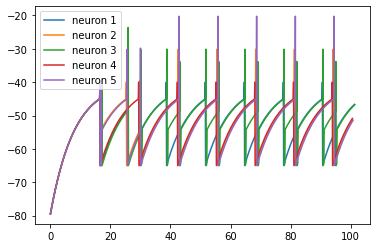

In [58]:
neuron_group1.neurons_u_plot()

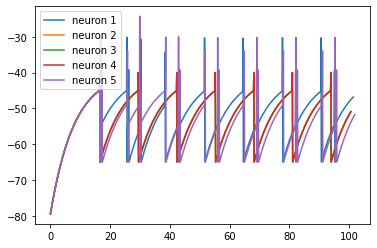

In [59]:
neuron_group2.neurons_u_plot()

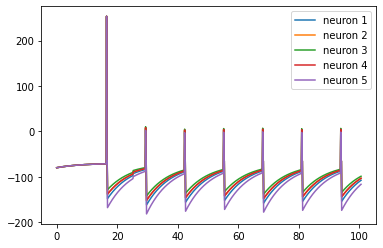

In [60]:
neuron_group3.neurons_u_plot()

Text(0.5, 1.0, 'Input current')

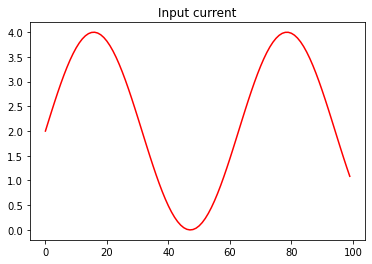

In [78]:
exc_I_1 = []
for i in range(100):
  I = lambda x: 2 * math.sin(x/10) + 2
  exc_I_1.append(I)


neuron_group1 = create_neuron_group(100, 100, 0, 0.01, 0, exc_I_1)
plt.plot(range(100), list(map(exc_I_1[0], range(100))), 'r')
plt.title('Input current')

Text(0.5, 1.0, 'Input current')

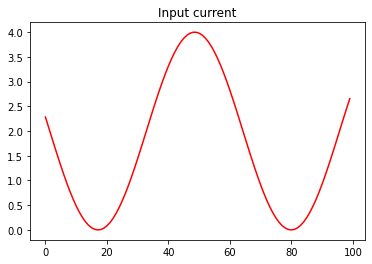

In [79]:
exc_I_2 = []
for i in range(100):
  I = lambda x: 2 * math.sin((x + 30)/10) + 2
  exc_I_2.append(I)


neuron_group2 = create_neuron_group(100, 100, 0, 0.01, 0, exc_I_2)
plt.plot(range(100), list(map(exc_I_2[0], range(100))), 'r')
plt.title('Input current')

Text(0.5, 1.0, 'Input current')

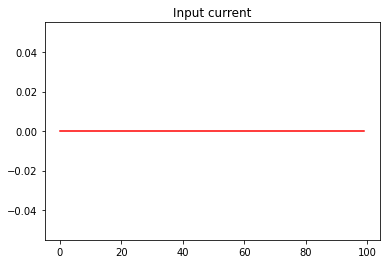

In [80]:
inh_I = []
for i in range(100):
  I = lambda x: 0
  inh_I.append(I)


neuron_group3 = create_neuron_group(100, 0, 100, 0, 0.1, inh_I)
plt.plot(range(100), list(map(inh_I[0], range(100))), 'r')
plt.title('Input current')

In [73]:
neuron_group1.connect(neuron_group3)
neuron_group2.connect(neuron_group3)

In [74]:
ng1 = neuron_group1.start()
ng2 = neuron_group2.start()
ng3 = neuron_group3.start()

for i in range(neuron_group1.iteration_count):
  next(ng1)
  next(ng2)
  next(ng3)

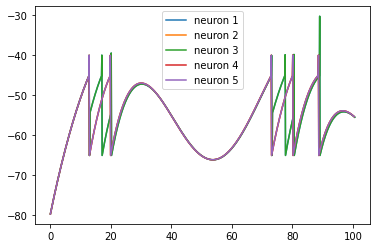

In [75]:
neuron_group1.neurons_u_plot()

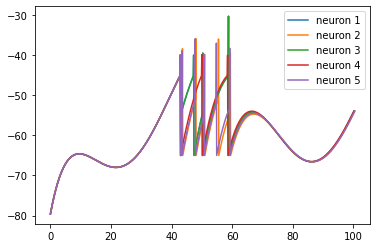

In [76]:
neuron_group2.neurons_u_plot()

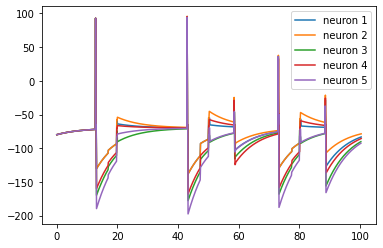

In [77]:
neuron_group3.neurons_u_plot()